In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox, interactive_output
from utils import (
    get_slider_values,
    symmetric_noise,
    generate_noisy_observations,
    enzyme_truth,
    plot_enzyme_truth,
    create_enzyme_widgets,
    extract_widget_values,
    Colors,
)
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.priors import LogNormalPrior
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ConstantMean, ZeroMean
from matplotlib import pyplot as plt
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.optim import optimize_acqf

dtype = torch.double

SEED = 12345

## Crude Extract
Assume we handle an unknown product broth that has shown to produce a desired product in substantial quantities. The present enzymes and pathways responsible for the production of said product are unknown. In an effort to maximize the product formation, we would like to identify the ideal pH.

## Ground Truth
The kinetics of our different enzyme shall be modeled by Michaelis-Menten. 

$$
v_i = \frac{V_{\text{max},i} [S_i]}{K_{m,i} + [S_i]}
$$

The influence of pH can be modeled as a Gaussian-like effect.

$$
v_i(pH) = v_{m,i} \exp\left(-\frac{(pH - pH_{\text{opt},i})^2}{2\sigma_i^2}\right)
$$


In [2]:
bounds_pH = (3.5, 10.5)

pH_values = np.linspace(bounds_pH[0], bounds_pH[1], 500)
num_enzymes = 3

# TODO: Check if parameters for Michaelis Menten are reasonable

config = {
    "Enzyme_1": {
        "Vmax": {"min": 5, "max": 30, "step": 1, "value": 10},
        "Km": {"min": 15, "max": 300, "step": 2, "value": 50},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 5.2},
        "sigma": {"min": 0.1, "max": 1.5, "step": 0.1, "value": 0.9},
    },
    "Enzyme_2": {
        "Vmax": {"min": 5, "max": 30, "step": 1, "value": 16},
        "Km": {"min": 15, "max": 300, "step": 2, "value": 70},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 7.3},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.5},
    },
    "Enzyme_3": {
        "Vmax": {"min": 5, "max": 30, "step": 1, "value": 22},
        "Km": {"min": 15, "max": 300, "step": 2, "value": 110},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 9.3},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.8},
    },
}

enzyme_widget, enzyme_sliders = create_enzyme_widgets(
    num_enzymes=num_enzymes, config=config
)


def update_plot(**kwargs):
    enzyme_params = list(extract_widget_values(enzyme_sliders).values())
    plot_enzyme_truth(pH_values, enzyme_params)


slider_kwargs = {
    f"{param}_{i+1}": enzyme_sliders[f"Enzyme_{i+1}"][param]
    for i in range(num_enzymes)
    for param in ["Vmax", "Km", "pH_opt", "sigma"]
}

interactive_plot = interactive_output(update_plot, slider_kwargs)

display(enzyme_widget, interactive_plot)

# TODO: Widgets are doubled? Why?

Output()

In [3]:
enzyme_params = list(extract_widget_values(enzyme_sliders).values())

In [4]:
def plot_noisy_samples(sigma_0, sigma_1, max_noise, bounds):

    enzyme_params = list(extract_widget_values(enzyme_sliders).values())

    x = np.linspace(bounds[0], bounds[1], 500)

    y_noisy = generate_noisy_observations(
        x=x,
        bounds=bounds,
        truth_fn=enzyme_truth,
        noise_fn=symmetric_noise,
        truth_params=enzyme_params,
        sigma_0=sigma_0,
        sigma_1=sigma_1,
        max_noise=max_noise,
        seed=SEED,
    )

    y_true, _ = enzyme_truth(x, enzyme_params)  # Unpack total rate and individual rates

    plt.figure(figsize=(10, 6))
    plt.plot(x, y_true, label="ground truth", color=Colors.light_blue, linewidth=2)
    plt.scatter(x, y_noisy, color=Colors.dark_blue, label="noisy observations")
    plt.legend()
    plt.show()


sigma_0_slider = widgets.FloatSlider(
    value=0.22, min=0.01, max=1, step=0.01, description="Sigma_0"
)
sigma_1_slider = widgets.FloatSlider(
    value=0.12, min=0.01, max=1, step=0.01, description="Sigma_1"
)
max_noise_slider = widgets.FloatSlider(
    value=0.55, min=0.1, max=1, step=0.05, description="Max Noise"
)


noise_sliders = {
    "sigma_0": sigma_0_slider,
    "sigma_1": sigma_1_slider,
    "max_noise": max_noise_slider,
}


controls = VBox([sigma_0_slider, sigma_1_slider, max_noise_slider])


widget = interactive_output(
    plot_noisy_samples,
    {
        "sigma_0": sigma_0_slider,
        "sigma_1": sigma_1_slider,
        "max_noise": max_noise_slider,
        "bounds": widgets.fixed(bounds_pH),
    },
)


display(VBox([controls, widget]))

In [5]:
# Extract current noise parameters (optional for further use)
noise_params = get_slider_values(noise_sliders)

### With custom ground truth and observation noise - Let's start modeling
Obtain initial datapoints. Utilize sobol sequence to generate initial space filling training data with the generate_noisy_observation function. 
6-8 points should be sufficient.


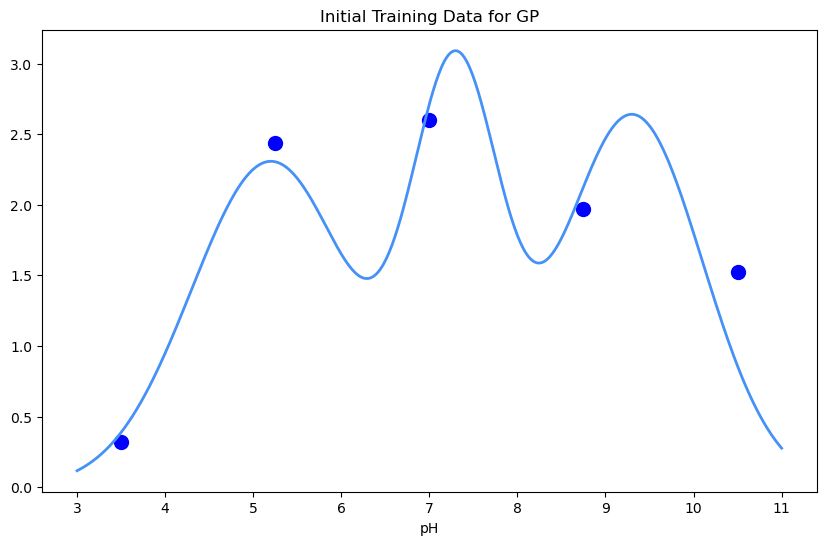

In [6]:
num_points = 5
x_init = np.linspace(bounds_pH[0], bounds_pH[1], num_points)


y_init = generate_noisy_observations(
    x=x_init,
    bounds=bounds_pH,
    truth_fn=enzyme_truth,
    noise_fn=symmetric_noise,
    truth_params=enzyme_params,
    noise_params=noise_params,
    seed=SEED,
)

train_x = torch.tensor(x_init, dtype=dtype).unsqueeze(-1)
train_y = torch.tensor(y_init, dtype=dtype).unsqueeze(-1)


plt.figure(figsize=(10, 6))
plt.scatter(
    train_x.numpy(),
    train_y.numpy(),
    color=Colors.dark_blue,
    label="Noisy Observations",
    s=100,
)
pH_range = np.linspace(3, 11, 500)


ground_truth, _ = enzyme_truth(
    pH_range, list(extract_widget_values(enzyme_sliders).values())
)
plt.plot(
    pH_range,
    ground_truth,
    color=Colors.light_blue,
    label="Ground Truth",
    linewidth=2,
)
plt.title("Initial Training Data for GP")
plt.xlabel("pH")
plt.show()

## Model Implementation

In [7]:
class EnzymeGP(SingleTaskGP):
    def __init__(self, train_x, train_y, bounds):
        super().__init__(train_x, train_y, outcome_transform=Standardize(m=1))

        self.covar_module = ScaleKernel(
            RBFKernel(
                lengthscale_prior=LogNormalPrior(
                    loc=np.log(np.abs(bounds[0] - bounds[1])) / 3, scale=0.5
                )
            )
        )
        self.mean_module = ConstantMean()
        self.mean_module.constant.data.fill_(train_y.mean().item())


def fit_gp_model(train_x, train_y, bounds):
    """
    Fit a Gaussian Process model to the training data.

    Parameters
    ----------
    train_x : torch.Tensor
        The training inputs.
    train_y : torch.Tensor
        The training targets.

    Returns
    -------
    model : CustomSingleTaskGP
        The fitted Gaussian Process model.
    """
    model = EnzymeGP(train_x, train_y, bounds)

    # Define the Marginal Log Likelihood (MLL)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    return model


gp_model = fit_gp_model(train_x=train_x, train_y=train_y, bounds=bounds_pH)

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


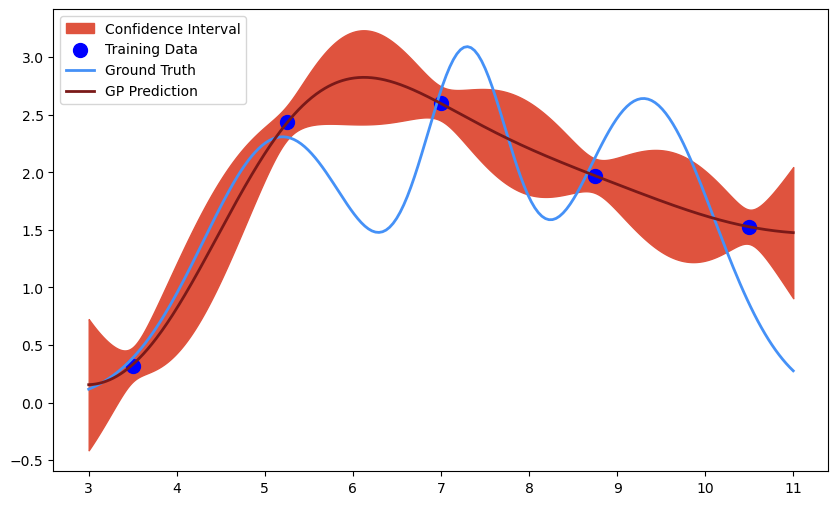

In [8]:
bounds_ax = (3, 11)

x_test = torch.linspace(bounds_ax[0], bounds_ax[1], 800).unsqueeze(-1)

gp_model.eval()
with torch.no_grad():
    posterior = gp_model.posterior(x_test)
    mean = posterior.mean
    lower, upper = posterior.mvn.confidence_region()

mean = mean.numpy()
lower = lower.numpy()
upper = upper.numpy()

plt.figure(figsize=(10, 6))

# Plot ground truth
x_ground_truth = np.linspace(bounds_ax[0], bounds_ax[1], 200)
y_ground_truth, _ = enzyme_truth(x_ground_truth, enzyme_params)

# Plot confidence intervals
plt.fill_between(
    x_test.squeeze(-1).numpy(),
    lower,
    upper,
    color=Colors.light_red,
    label="Confidence Interval",
)

# Plot training data
plt.scatter(
    train_x.numpy(),
    train_y.numpy(),
    color=Colors.dark_blue,
    label="Training Data",
    s=100,
)

plt.plot(
    x_ground_truth,
    y_ground_truth,
    label="Ground Truth",
    color=Colors.light_blue,
    linewidth=2,
)
plt.plot(
    x_test.numpy(), mean, label="GP Prediction", color=Colors.dark_red, linewidth=2
)

plt.legend()
plt.show()

## The Acquisition functions

In [9]:
def perform_EI(train_x, train_y, bounds, num_candidates):
    gp_model = fit_gp_model(train_x, train_y, bounds)
    best_f = train_y.max().item()
    bounds = torch.tensor(bounds, dtype=dtype).view(2, -1)
    qei = qExpectedImprovement(model=gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=qei,
        bounds=bounds,
        q=num_candidates,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, gp_model, qei

In [10]:
def perform_logEI(train_x, train_y, bounds, num_candidates):
    gp_model = fit_gp_model(train_x, train_y, bounds)
    best_f = train_y.max().item()
    bounds = torch.tensor(bounds, dtype=dtype).view(2, -1)
    qlog_ei = qLogExpectedImprovement(model=gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=qlog_ei,
        bounds=bounds,
        q=num_candidates,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, gp_model, qlog_ei

## Collected BO Visualization

In [11]:
def perform_bo_collect_data(
    train_x, train_y, bounds, num_candidates, num_rounds, method="EI", seed=None
):
    """
    Perform multiple rounds of Bayesian Optimization and collect data for visualization.

    Parameters
    ----------
    train_x : torch.Tensor
        Initial training inputs.
    train_y : torch.Tensor
        Initial training outputs.
    bounds : torch.Tensor
        Input domain bounds.
    num_candidates : int
        Number of candidates to propose in each round.
    num_rounds : int
        Number of BO rounds.
    method : str, optional
        Optimization method: "EI" (Expected Improvement) or "TS" (Thompson Sampling).
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    dict
        A dictionary containing:
        - gp_models: List of GP models from each round.
        - acquisition_fns: List of acquisition functions from each round.
        - train_x_per_round: List of training inputs for each round.
        - train_y_per_round: List of training outputs for each round.
        - candidates_per_round: List of proposed candidates for each round.
    """
    gp_models = []
    acquisition_fns = []
    train_x_per_round = [train_x]
    train_y_per_round = [train_y]
    candidates_per_round = []

    for round_idx in range(num_rounds):
        print(f"Round {round_idx + 1}/{num_rounds}")

        # Perform the chosen acquisition strategy
        if method == "EI":
            candidates, gp_model, acquisition_fn = perform_EI(
                train_x, train_y, bounds, num_candidates
            )
        elif method == "logEI":
            candidates, gp_model, acquisition_fn = perform_logEI(
                train_x, train_y, bounds, num_candidates
            )
        else:
            raise ValueError("Unsupported method. Use 'EI' or 'logEI'.")

        enzyme_params = list(extract_widget_values(enzyme_sliders).values())
        # Simulate observing new data
        new_y = generate_noisy_observations(
            x=candidates.numpy().flatten(),
            bounds=bounds,
            truth_fn=enzyme_truth,
            noise_fn=symmetric_noise,
            truth_params=enzyme_params,
            noise_params=noise_params,
            seed=seed + round_idx if seed is not None else None,
        )

        new_y = torch.tensor(new_y, dtype=dtype).reshape(-1, 1)
        # Update training data
        train_x = torch.cat([train_x, candidates], dim=0)
        train_y = torch.cat([train_y, new_y], dim=0)

        # Collect data for visualization
        gp_models.append(gp_model)
        acquisition_fns.append(acquisition_fn)
        train_x_per_round.append(train_x.clone())  # Use clone to preserve state
        train_y_per_round.append(train_y.clone())
        candidates_per_round.append(candidates)

    return {
        "gp_models": gp_models,
        "acquisition_fns": acquisition_fns,
        "train_x_per_round": train_x_per_round,
        "train_y_per_round": train_y_per_round,
        "candidates_per_round": candidates_per_round,
    }

In [17]:
def plot_combined_gp_and_acquisition_from_results(
    results, bounds, truth_fn=None, truth_params=None
):
    """
    Plot GP models and acquisition functions for multiple rounds of BO using results dictionary.

    Parameters
    ----------
    results : dict
        Dictionary containing:
        - gp_models: List of GP models from each round.
        - acquisition_fns: List of acquisition functions from each round.
        - train_x_per_round: List of training inputs for each round.
        - train_y_per_round: List of training outputs for each round.
        - candidates_per_round: List of proposed candidates for each round.
    bounds : torch.Tensor
        Bounds of the search space as a tensor of shape (2, d).
    truth_fn : callable, optional
        Ground truth function for comparison (if available).
    truth_params : dict, optional
        Parameters for the truth function (if any).
    """
    gp_models = results["gp_models"]
    acquisition_fns = results["acquisition_fns"]
    train_x_per_round = results["train_x_per_round"]
    train_y_per_round = results["train_y_per_round"]
    candidates_per_round = results["candidates_per_round"]

    # Set subplot layout
    num_rounds = len(gp_models)
    num_columns = 2
    num_rows = num_rounds * 2 // num_columns + (num_rounds * 2 % num_columns > 0)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 2.5))
    axes = axes.flatten()

    x_test = torch.linspace(bounds[0], bounds[1], 500).unsqueeze(-1)

    # Allocate plots
    for round_idx in range(num_rounds):
        gp_plot_idx = (round_idx // num_columns) * num_columns * 2 + (
            round_idx % num_columns
        )
        acq_plot_idx = gp_plot_idx + num_columns

        ax1 = axes[gp_plot_idx]
        ax2 = axes[acq_plot_idx]

        # Obtain mean and variance of the model's predictions
        with torch.no_grad():
            posterior = gp_models[round_idx].posterior(x_test)
            mean = posterior.mean.numpy()
            lower, upper = posterior.mvn.confidence_region()
            acquisition_values = (
                acquisition_fns[round_idx](x_test.unsqueeze(-2))
                .detach()
                .numpy()
                .squeeze()
            )

        # Evaluate the ground truth function
        if truth_fn is not None and truth_params is not None:
            total_rate, rates = truth_fn(x_test.numpy(), **truth_params)
            truth_values = total_rate

        # Plot the GP mean and confidence intervals
        ax1.fill_between(
            x_test.squeeze(-1).numpy(),
            lower.numpy(),
            upper.numpy(),
            color=Colors.light_red,
            label="Confidence Interval",
        )

        ax1.plot(x_test.numpy(), mean, color=Colors.dark_red, label="GP Mean")

        initial_points = len(train_x_per_round[0])
        for i, (x, y) in enumerate(
            zip(train_x_per_round[round_idx], train_y_per_round[round_idx])
        ):
            # plot and annotate observation scatter
            if i < initial_points:
                ax1.scatter(x.numpy(), y.numpy(), color=Colors.dark_blue, s=100)
            elif round_idx > 0 and i == len(train_x_per_round[round_idx]) - 1:
                ax1.scatter(
                    x.numpy(),
                    y.numpy(),
                    color="orange",
                    label="Latest Observation",
                    s=100,
                )
                ax1.annotate(
                    str(i + 1 - initial_points),
                    (x.numpy(), y.numpy()),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha="center",
                    fontsize=10,
                )
            else:
                ax1.scatter(x.numpy(), y.numpy(), color=Colors.dark_blue, s=100)
                ax1.annotate(
                    str(i + 1 - initial_points),
                    (x.numpy(), y.numpy()),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha="center",
                    fontsize=8,
                )
        ax1.axvline(
            x=candidates_per_round[round_idx],
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.5,
            label="Proposed Candidate",
        )
        if truth_fn is not None and truth_params is not None:
            ax1.plot(
                x_test.numpy(),
                truth_values,
                color=Colors.light_blue,
                label="Ground Truth",
                linestyle="--",
            )

        ax1.set_title(f"Round {round_idx + 1}")
        ax1.set_ylabel(
            "reaction rate [mmol/min]"  # TODO: Change label according to selected units
        )

        # Plot the acquisition function
        ax2.plot(x_test.squeeze(-1).numpy(), acquisition_values, color=Colors.alt_blue)
        ax2.axvline(
            x=candidates_per_round[round_idx],
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.5,
            label="Proposed Candidate",
        )
        ax2.yaxis.set_ticks([])
        ax2.set_ylabel("Acquisition Value")
        ax2.set_xlabel("pH [-]")

    # Hide unused axes
    for ax in axes[len(gp_models) * 2 :]:
        ax.axis("off")

    plt.tight_layout(h_pad=0.5, w_pad=1.5)  # Reduce vertical space between plots
    plt.show()


def plot_selected_rounds(
    results, bounds, selected_rounds, truth_fn=None, truth_params=None
):
    """
    Plot selected GP models and acquisition functions for specific rounds in one column.

    Parameters
    ----------
    results : dict
        Dictionary containing:
        - gp_models: List of GP models from each round.
        - acquisition_fns: List of acquisition functions from each round.
        - train_x_per_round: List of training inputs for each round.
        - train_y_per_round: List of training outputs for each round.
        - candidates_per_round: List of proposed candidates for each round.
    bounds : torch.Tensor
        Bounds of the search space as a tensor of shape (2, d).
    selected_rounds : list of int
        List of round indices to visualize (0-based indexing).
    truth_fn : callable, optional
        Ground truth function for comparison (if available).
    truth_params : dict, optional
        Parameters for the truth function (if any).
    """
    gp_models = results["gp_models"]
    acquisition_fns = results["acquisition_fns"]
    train_x_per_round = results["train_x_per_round"]
    train_y_per_round = results["train_y_per_round"]
    candidates_per_round = results["candidates_per_round"]

    num_selected = len(selected_rounds)
    fig, axes = plt.subplots(
        num_selected * 2, 1, figsize=(8, num_selected * 6)
    )
    if num_selected == 1:
        axes = [axes]

    x_test = torch.linspace(bounds[0], bounds[1], 500).unsqueeze(-1)

    for plot_idx, round_idx in enumerate(selected_rounds):
        ax1 = axes[plot_idx * 2]
        ax2 = axes[plot_idx * 2 + 1]

        # Obtain mean and variance of the model's predictions
        with torch.no_grad():
            posterior = gp_models[round_idx].posterior(x_test)
            mean = posterior.mean.numpy()
            lower, upper = posterior.mvn.confidence_region()
            acquisition_values = (
                acquisition_fns[round_idx](x_test.unsqueeze(-2))
                .detach()
                .numpy()
                .squeeze()
            )

        # Evaluate the ground truth function
        if truth_fn is not None and truth_params is not None:
            total_rate, _ = truth_fn(x_test.numpy(), **truth_params)
            truth_values = total_rate

        # Plot the GP mean and confidence intervals

        ax1.fill_between(
            x_test.squeeze(-1).numpy(),
            lower.numpy(),
            upper.numpy(),
            color=Colors.light_red,
            label="Confidence Interval",
        )

        ax1.plot(x_test.numpy(), mean, color=Colors.dark_red, label="GP Mean")


        initial_points = len(train_x_per_round[0])  # Number of initial points
        for i, (x, y) in enumerate(
            zip(train_x_per_round[round_idx], train_y_per_round[round_idx])
        ):
            if i < initial_points:
                ax1.scatter(x.numpy(), y.numpy(), color=Colors.dark_blue, s=100)
            elif round_idx > 0 and i == len(train_x_per_round[round_idx]) - 1:
                ax1.scatter(
                    x.numpy(), y.numpy(), color="orange", label="Latest Observation", s=100
                )
                ax1.annotate(
                    str(i + 1 - initial_points),
                    (x.numpy(), y.numpy()),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha="center",
                    fontsize=8,
                )
            else:
                ax1.scatter(x.numpy(), y.numpy(), color=Colors.dark_blue, s=100)
                ax1.annotate(
                    str(i + 1 - initial_points),
                    (x.numpy(), y.numpy()),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha="center",
                    fontsize=8,
                )
        ax1.axvline(
            x=candidates_per_round[round_idx],
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.5,
            label="Proposed Candidate",
        )
        if truth_fn is not None and truth_params is not None:
            ax1.plot(
                x_test.numpy(),
                truth_values,
                color=Colors.light_blue,
                label="Ground Truth",
                linestyle="--",
            )

        ax1.set_title(f"Round {round_idx + 1} - GP Model")
        ax1.set_ylabel(
            "reaction rate [mmol/min]"
        )  # TODO: Change label according to selected units

        # Plot the acquisition function
        ax2.plot(x_test.squeeze(-1).numpy(), acquisition_values, color=Colors.alt_blue)
        ax2.axvline(
            x=candidates_per_round[round_idx],
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.5,
            label="Proposed Candidate",
        )
        ax2.yaxis.set_ticks([])
        ax2.set_ylabel("Acquisition Value")
        ax2.set_xlabel("pH [-]")

    plt.tight_layout(h_pad=1.0)  # Adjust vertical spacing further
    plt.show()

Round 1/8
Round 2/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data

Round 3/8
Round 4/8
Round 5/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It i

Round 6/8
Round 7/8
Round 8/8


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


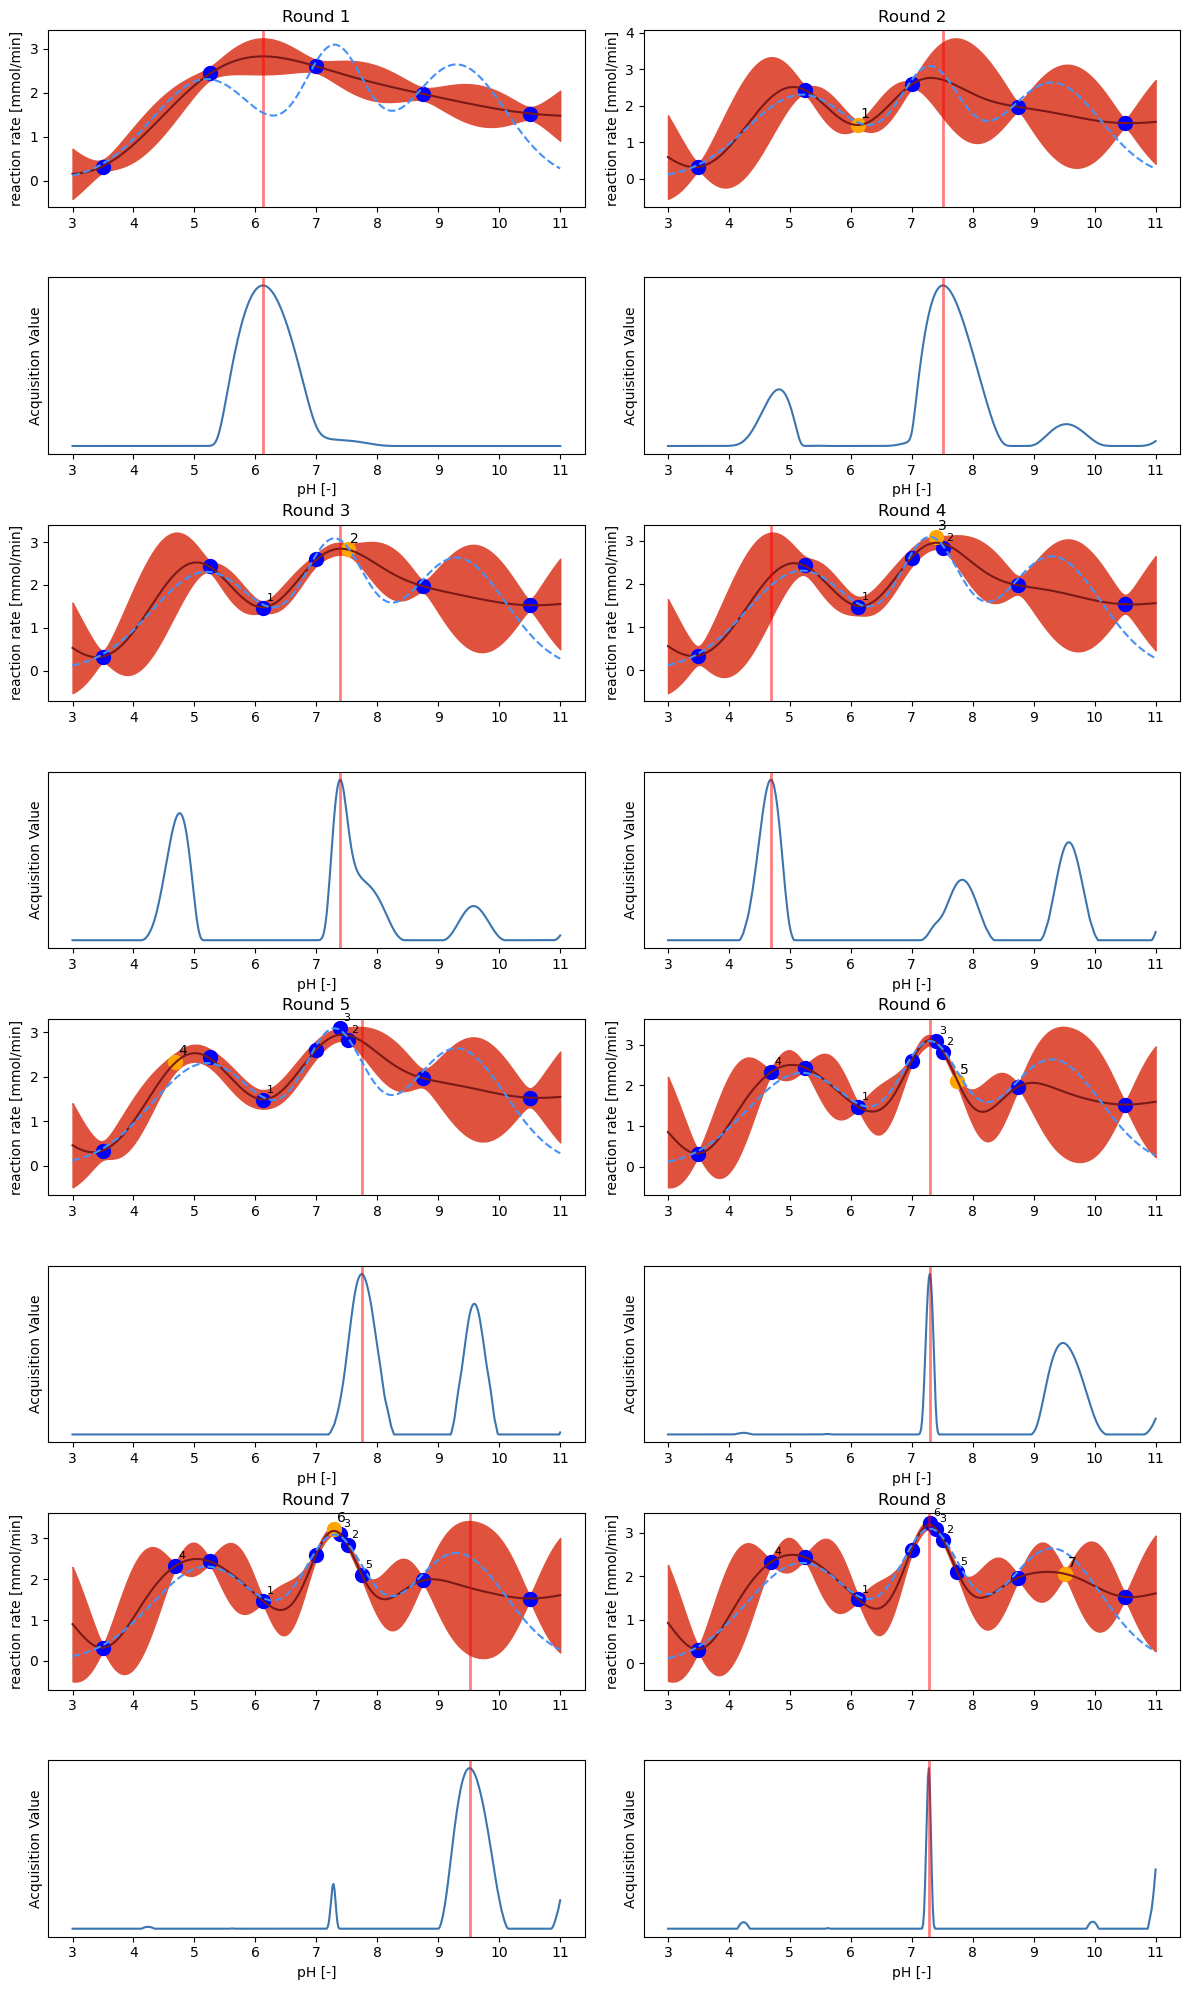

In [21]:
results = perform_bo_collect_data(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_pH,
    num_candidates=1,
    num_rounds=8,
    method="EI",
    seed=SEED,
)

plot_combined_gp_and_acquisition_from_results(
    results=results,
    bounds=bounds_ax,
    truth_fn=enzyme_truth,
    truth_params={"enzyme_params": enzyme_params},
)

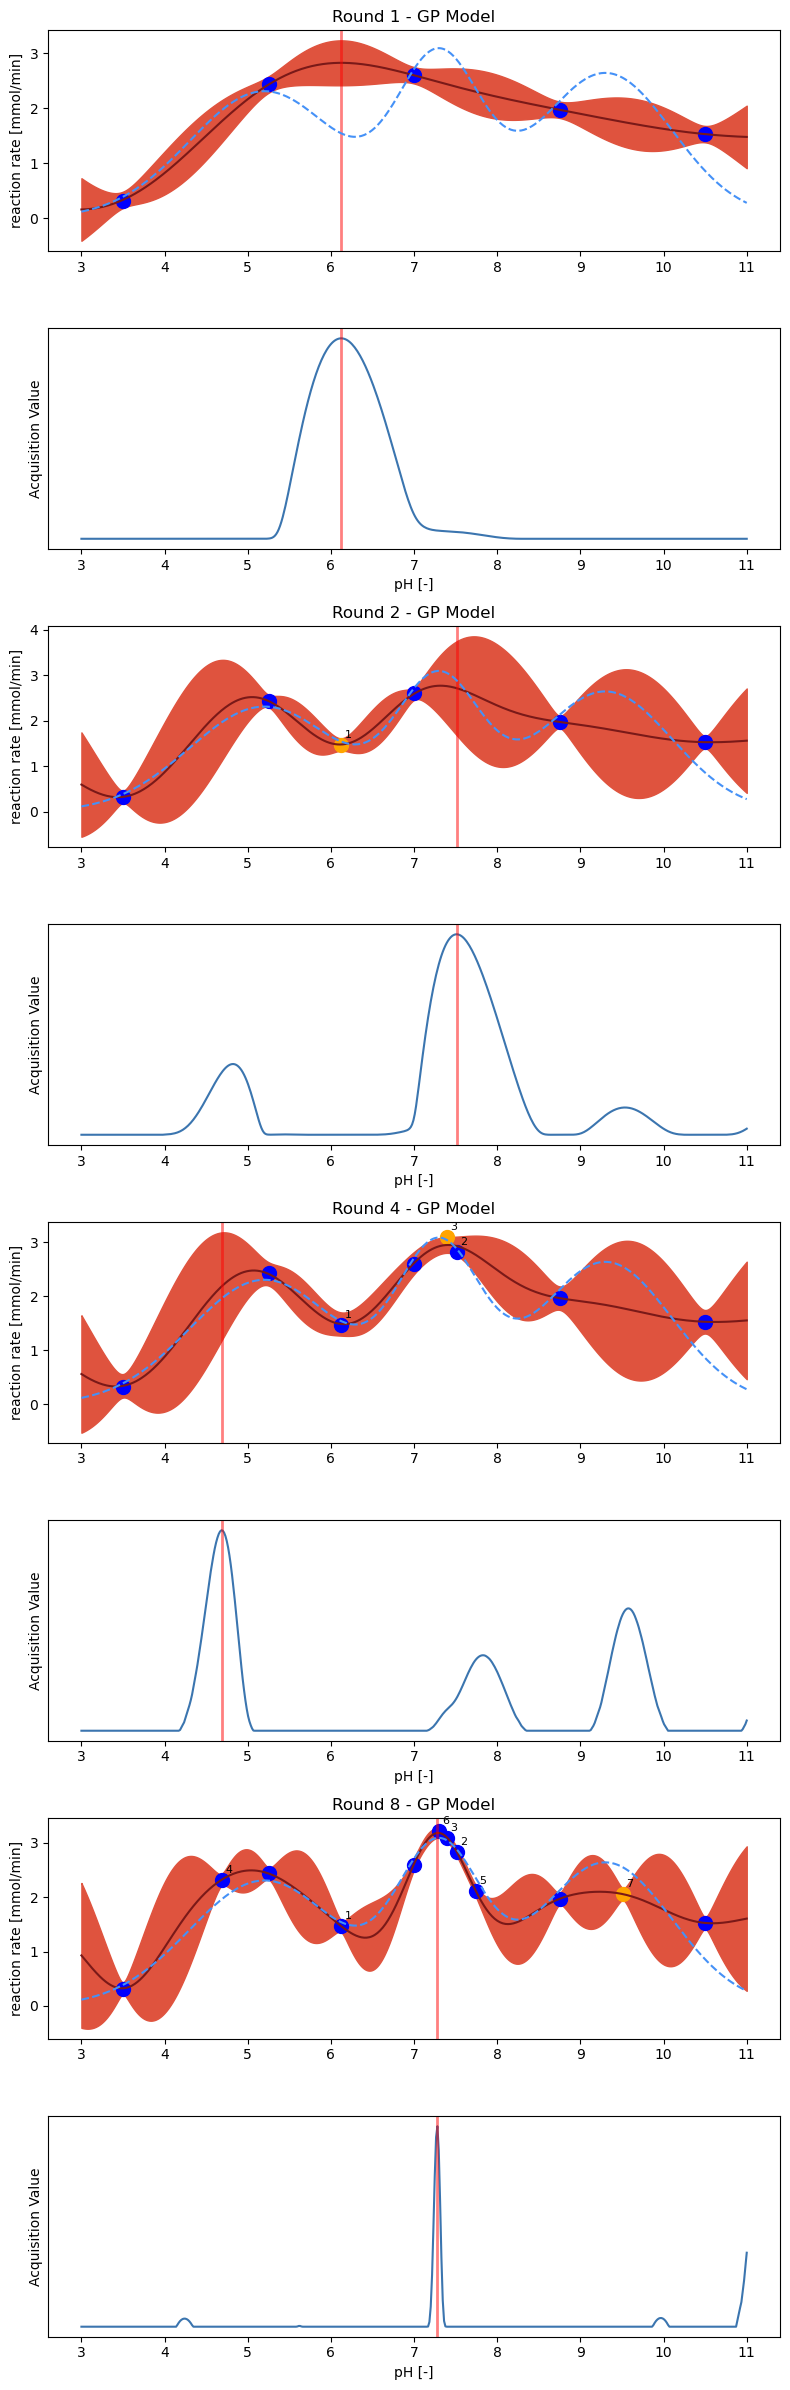

In [22]:
plot_selected_rounds(
    results=results,
    bounds=bounds_ax,
    selected_rounds=[0, 1, 3, 7],
    truth_fn=enzyme_truth,
    truth_params={"enzyme_params": enzyme_params},
)